## Topic Modeling - Gensim

NOTE: Review used for modeling was picked based on business_id, I only picked those given to certain businesses, specifically to those received more than 3,000 reviews in total. 
There are 30 restaurants qualified for that standard. 

The dataset contains 58,972 rows and 7 columns. 

In [0]:
import re
import numpy as np
import pandas as pd
import json
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from smart_open import smart_open

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import zipfile

In [0]:
!pip install pyLDAvis

### 1. Import Stopwords

In [0]:
import nltk
nltk.download('stopwords')

In [8]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['restaurant', 'restaurants'])
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### 2. Import dataset

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

% cd /content/gdrive/Shared\ drives/IMT\ 575\ Project\ Group/1\ Data\ Cleaning/new\ data


In [10]:
!unzip '/content/gdrive/Shared drives/IMT 575 Project Group/1 Data Cleaning/new data/reviews_join_textblob_cleaned_v2.txt.zip'

Archive:  /content/gdrive/Shared drives/IMT 575 Project Group/1 Data Cleaning/new data/reviews_join_textblob_cleaned_v2.txt.zip
replace reviews_join_textblob_cleaned_v2.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


method 1 : Process one line at a time

In [33]:
class BoWcorpus():
    '''create corpus for a file, reading line by line
    format : nested list, (word, word count)
    @ filename : file name or path
    @ dictionary : corpora.Dictionary()
    '''
    def __init__(self, filename, dictionary):
        self.filename = filename
        self.dictionary = dictionary

    def __iter__(self):
        global my_dict 
        c = 0
        for line in smart_open(self.filename, encoding = 'utf-8'):
            c += 1
            if c > 10: break #testing

            # get only text 
            line = line.split('|')
            text = line[6]

            #tokenize
            tokenize_list = simple_preprocess(str(text), deacc = True) # deacc = True removes punctuations

            #create bag of words
            bow = self.dictionary.doc2bow(tokenized_list, allow_update = True)

            # update the dictionary
            my_dict.merge_with(self.dictionary)
            
            #yield returns a series of values without storing them in memory
            yield bow

#create the dictionary
my_dict = corpora.Dictionary()

#create corpus
#format: a nested list of one list representing one file
# within small lists are tuples(id, word count)
bow_corpus = BoWcorpus('reviews_join_textblob_cleaned_v2.txt', my_dict)

#print
for line in bow_corpus:
    print(line)


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


TypeError: ignored

In [0]:
#create corpus

my_corpus = [mydict.doc2bow(word, allow_update = True) for word in tokenized_list]
#pprint(my_corpus)

#get word count
word_counts = [[(mydict[id], count) for id, count in line] for line in my_corpus]
#pprint(word_counts)

In [19]:
print(tokenized_list)

[['went', 'in', 'for', 'lunch', 'steak', 'sandwich', 'was', 'delicious', 'and', 'the', 'caesar', 'salad', 'had', 'an', 'absolutely', 'delicious', 'dressing', 'with', 'perfect', 'amount', 'of', 'dressing', 'and', 'distributed', 'perfectly', 'across', 'each', 'leaf', 'know', 'going', 'on', 'about', 'the', 'salad', 'but', 'it', 'was', 'perfect', 'drink', 'prices', 'were', 'pretty', 'good', 'the', 'server', 'dawn', 'was', 'friendly', 'and', 'accommodating', 'very', 'happy', 'with', 'her', 'in', 'summation', 'great', 'pub', 'experience', 'would', 'go', 'again'], ['ll', 'be', 'the', 'first', 'to', 'admit', 'that', 'was', 'not', 'excited', 'about', 'going', 'to', 'la', 'tavolta', 'being', 'food', 'snob', 'when', 'group', 'of', 'friends', 'suggested', 'we', 'go', 'for', 'dinner', 'looked', 'online', 'at', 'the', 'menu', 'and', 'to', 'me', 'there', 'was', 'nothing', 'special', 'and', 'it', 'seemed', 'overpriced', 'im', 'also', 'not', 'big', 'on', 'ordering', 'pasta', 'when', 'go', 'out', 'alas'

### 3. data cleaning 
- remove newline characters and punctions
- tokenize

In [11]:
#convert all review text to 
data = df.text.values.tolist()
print(data[0])

 Went in for a lunch. Steak sandwich was delicious, and the Caesar salad had an absolutely delicious dressing, with a perfect amount of dressing, and distributed perfectly across each leaf. I know I'm going on about the salad ... But it was perfect.Drink prices were pretty good.The Server, Dawn, was friendly and accommodating. Very happy with her.In summation, a great pub experience. Would go again! 


In [0]:
#tokenize
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

### 4. Creating bigram and trigram model

In [0]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=50)  # by default, min_count = 5, threshold = 5

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[10]]])

['hands_down', 'the', 'best', 'place', 'to', 'eat', 'in', 'vegas', 'the', 'food', 'is', 'priced', 'well', 'and', 'the', 'food', 'is', 'delicious', 'would', 'have', 'eaten', 'here', 'everyday', 'if', 'known', 'this', 'place', 'was', 'here', 'my', 'wife', 'absolutely', 'loves', 'this', 'place', 'as', 'well', 'service', 'was', 'awesome', 'which', 'is', 'bonus']


In [0]:
print(trigram_mod[bigram_mod[data_words[36]]])

['my', 'gf', 'suggested', 'we', 'eat', 'here', 'because', 'they', 'have', 'better', 'food', 'which', 'suppose', 'is', 'implied', 'by', 'the', 'higher', 'price', 'they', 'charge', 'for', 'dinner', 'this', 'is', 'not', 'the', 'case', 'when', 'you', 're', 'in', 'vegas', 'or', 'anywhere', 'really', 'you', 'have', 'to', 'remember', 'that', 'buffet', 'is', 'buffet', 'is', 'buffet', 'sure', 'they', 've', 'got', 'kobe', 'not', 'really', 'we', 'aren', 'in', 'japan', 'beef', 'lamb', 'sushi', 'alaskan_king_crab_legs', 'snow_crab', 'flank_steak', 'shrimp_cocktail', 'but', 'it', 'all', 'tastes', 'like', 'buffet', 'quality', 'food', 'which', 'is', 'better', 'way', 'of', 'saying', 'they', 're', 'mostly', 'terrible', 'do', 'you', 'know', 'how', 'difficult', 'it', 'must', 'be', 'to', 'coordinate', 'meal', 'big', 'enough', 'to', 'feed', 'hundreds', 'if', 'not', 'thousands', 'or', 'people', 'do', 'you', 'possibly', 'think', 'quality', 'can', 'be', 'factor', 'in', 'cooking', 'these', 'meals', 'where', 'is

### 5. remove stopwords, make bigrams and lemmatize 

In [0]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [0]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['last', 'night', 'service', 'server', 'great', 'kind', 'forget', 'end', 'visit', 'food', 'cold', 'good', 'thing', 'crab_leg', 'suppose', 'cold', 'taco', 'freshly', 'make', 'food', 'single', 'lamp', 'heat', 'food', 'let', 'server', 'know', 'food', 'tell', 'manager', 'charge', 'come', 'ask', 'problem', 'say', 'go', 'talk', 'chief', 'idea', 'actually', 'happen', 'see', 'half', 'buffet', 'close', 'well', 'many', 'option', 'say', 'rather', 'go', 'buffet', 'high', 'end', 'casino', 'horrible', 'experience']]


### 6. create the dictionary and corpus needed for topic modeling 

In [0]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 2), (11, 1), (12, 4), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 2), (37, 1), (38, 2), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1)]]


In [0]:
#print corpus - (term - frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('actually', 1),
  ('ask', 1),
  ('buffet', 2),
  ('casino', 1),
  ('charge', 1),
  ('chief', 1),
  ('close', 1),
  ('cold', 2),
  ('come', 1),
  ('crab_leg', 1),
  ('end', 2),
  ('experience', 1),
  ('food', 4),
  ('forget', 1),
  ('freshly', 1),
  ('go', 2),
  ('good', 1),
  ('great', 1),
  ('half', 1),
  ('happen', 1),
  ('heat', 1),
  ('high', 1),
  ('horrible', 1),
  ('idea', 1),
  ('kind', 1),
  ('know', 1),
  ('lamp', 1),
  ('last', 1),
  ('let', 1),
  ('make', 1),
  ('manager', 1),
  ('many', 1),
  ('night', 1),
  ('option', 1),
  ('problem', 1),
  ('rather', 1),
  ('say', 2),
  ('see', 1),
  ('server', 2),
  ('service', 1),
  ('single', 1),
  ('suppose', 1),
  ('taco', 1),
  ('talk', 1),
  ('tell', 1),
  ('thing', 1),
  ('visit', 1),
  ('well', 1)]]

### 7. building the topic model

In [0]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,  #set topic number to 10
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [0]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.164*"food" + 0.036*"price" + 0.034*"pretty" + 0.033*"well" + 0.033*"much" '
  '+ 0.029*"worth" + 0.027*"good" + 0.025*"line" + 0.020*"star" + 0.020*"lot"'),
 (1,
  '0.091*"wait" + 0.050*"server" + 0.046*"table" + 0.045*"order" + '
  '0.043*"take" + 0.036*"minute" + 0.029*"ask" + 0.026*"check" + '
  '0.025*"people" + 0.023*"busy"'),
 (2,
  '0.055*"come" + 0.053*"get" + 0.050*"go" + 0.038*"time" + 0.028*"back" + '
  '0.027*"eat" + 0.020*"say" + 0.020*"make" + 0.018*"even" + 0.017*"give"'),
 (3,
  '0.109*"strip" + 0.046*"mushroom" + 0.030*"diner" + 0.023*"entire" + '
  '0.022*"bottom" + 0.021*"traditional" + 0.021*"dog" + 0.021*"pass" + '
  '0.020*"exceptional" + 0.020*"host"'),
 (4,
  '0.058*"potato" + 0.031*"taste" + 0.030*"flavor" + 0.027*"pho" + '
  '0.027*"side" + 0.026*"serve" + 0.025*"top" + 0.024*"cheese" + 0.023*"dish" '
  '+ 0.023*"cook"'),
 (5,
  '0.323*"burger" + 0.220*"fry" + 0.042*"truffle" + 0.024*"gordon_ramsay" + '
  '0.020*"joint" + 0.017*"burgr" + 0.016*"mediu

### 8. compute model perplexity and coherence score

preplexity: -7.6496
coherence: 0.3946

In [0]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.649654729442619


/Users/rainbowhuang/.local/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/Users/rainbowhuang/.local/lib/python3.7/site-packages/scipy/sparse/lil.py:506: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):



Coherence Score:  0.3946798712239633


### 9. visualize the topics -keywords

In [0]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.272086 -0.124772       1        1  25.570688
2      0.115432  0.056345       2        1  25.229969
0      0.217921  0.090594       3        1  13.829927
1      0.156340 -0.236426       4        1  10.840468
4      0.046538  0.375589       5        1  10.501698
9     -0.140424  0.016159       6        1   4.861615
5     -0.154194 -0.046974       7        1   3.440781
8     -0.141538 -0.046580       8        1   3.040566
3     -0.186082 -0.044938       9        1   1.617773
7     -0.186080 -0.038998      10        1   1.066517, topic_info=     Category           Freq        Term          Total  loglift  logprob
12    Default  113826.000000        food  113826.000000  30.0000  30.0000
53    Default   54083.000000      burger   54083.000000  29.0000  29.0000
173   Default   36807.000000         fry   36807.000000  28.0000  28.0000
347   Default   33972.000000   breakfast   33972.000000  27.0000  27.0000
134   Default   48250.000000        wait   48250.000000  26.0000  26.0000
...       ...            ...         ...            ...      ...      ...
1946  Topic10     512.915039        ruin     514.049194   4.5386  -4.6180
1704  Topic10     499.933411    ordinary     501.067688   4.5385  -4.6436
1407  Topic10     483.335632         pro     484.469818   4.5384  -4.6774
2353  Topic10     468.342255  frequently     469.476532   4.5384  -4.7089
1637  Topic10     448.900940  write_home     450.035278   4.5382  -4.7513

[377 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
288       5  0.999834         add
385       9  0.998949  affordable
169       1  0.968561        also
169       3  0.028757        also
169       5  0.002655        also
...     ...       ...         ...
951       2  0.399822        work
951       4  0.600118        work
2271     10  0.999329       world
168       3  0.999969       worth
1637     10  0.997700  write_home

[385 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 1, 2, 5, 10, 6, 9, 4, 8])

### 10. Builid a LDA Mallet Model

coherence socre : 0.4479501138412729

In [0]:
mallet_path = '../mallet-2.0.8/bin/mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [0]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('burger', 0.08836882999986763),
   ('fry', 0.07415251432882841),
   ('good', 0.05618224416588349),
   ('order', 0.04786424345109667),
   ('cheese', 0.01916158153202642),
   ('love', 0.013379750354084213),
   ('menu', 0.01241081710723126),
   ('friend', 0.011772803685123168),
   ('taste', 0.011097727242643652),
   ('delicious', 0.010181741167749878)]),
 (1,
  [('good', 0.04833776477999196),
   ('dish', 0.03847389578552979),
   ('sauce', 0.028349452667848947),
   ('flavor', 0.02652290395946175),
   ('meat', 0.0231379702034755),
   ('taste', 0.019211649434199975),
   ('order', 0.017359802267247856),
   ('make', 0.014743941651635166),
   ('beef', 0.01365357808748713),
   ('soup', 0.012747893270863007)]),
 (2,
  [('place', 0.0656411692122645),
   ('night', 0.03196513930797067),
   ('find', 0.030277579037961033),
   ('pizza', 0.02605478997521801),
   ('eat', 0.01933306373845149),
   ('slice', 0.014488132640681868),
   ('day', 0.01404226418224614),
   ('open', 0.013357907943716885),


### 11. Find the optimal number of topics for LDA

In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [0]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

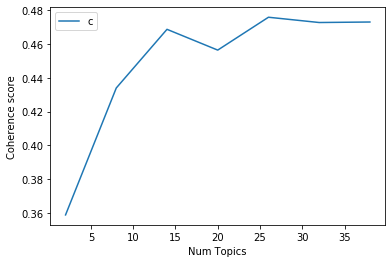

In [0]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [0]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3588
Num Topics = 8  has Coherence Value of 0.4341
Num Topics = 14  has Coherence Value of 0.4688
Num Topics = 20  has Coherence Value of 0.4565
Num Topics = 26  has Coherence Value of 0.476
Num Topics = 32  has Coherence Value of 0.4729
Num Topics = 38  has Coherence Value of 0.4732


In [0]:
# Select the model and print the topics
optimal_model = model_list[2] # topic number of 14
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.041*"place" + 0.040*"find" + 0.036*"pizza" + 0.035*"night" + '
  '0.020*"slice" + 0.013*"walk" + 0.012*"late" + 0.012*"hotel" + 0.010*"white" '
  '+ 0.010*"casino"'),
 (1,
  '0.092*"place" + 0.058*"good" + 0.056*"sandwich" + 0.043*"love" + '
  '0.029*"delicious" + 0.022*"lunch" + 0.019*"friend" + 0.019*"open" + '
  '0.019*"eat" + 0.018*"super"'),
 (2,
  '0.123*"burger" + 0.103*"fry" + 0.059*"order" + 0.028*"good" + 0.015*"taste" '
  '+ 0.015*"cheese" + 0.014*"shake" + 0.013*"menu" + 0.013*"flavor" + '
  '0.013*"truffle"'),
 (3,
  '0.136*"wait" + 0.072*"line" + 0.062*"time" + 0.053*"long" + 0.042*"minute" '
  '+ 0.040*"hour" + 0.035*"seat" + 0.032*"people" + 0.019*"pay" + '
  '0.018*"table"'),
 (4,
  '0.043*"star" + 0.033*"give" + 0.033*"food" + 0.032*"bad" + 0.031*"taste" + '
  '0.028*"review" + 0.024*"chocolate" + 0.023*"expect" + 0.017*"high" + '
  '0.015*"quality"'),
 (5,
  '0.234*"good" + 0.129*"food" + 0.069*"eat" + 0.066*"pretty" + 0.060*"place" '
  '+ 0.041*"price" + 0

### 12. find the dominant topic in each sentence

In [0]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.1246,"star, give, food, bad, taste, review, chocolat...",We had dinner at the Bellagio Buffet last nig...
1,1,12.0,0.1871,"sauce, flavor, cook, perfectly, side, top, bre...",Wonderful experience. We sat outside on the p...
2,2,5.0,0.1234,"good, food, eat, pretty, place, price, thing, ...","""Good morning, cocktails for you?"" Wait...wha..."
3,3,2.0,0.1049,"burger, fry, order, good, taste, cheese, shake...",Hands down best Bloody Mary ever. So many thi...
4,4,3.0,0.0950,"wait, line, time, long, minute, hour, seat, pe...","Service was amazing, Christina was extremely ..."
5,5,9.0,0.1062,"steak, order, dinner, reservation, meal, sit, ...",Around $45 for a dinner on a Friday night.Sno...
6,6,7.0,0.1484,"buffet, dessert, selection, quality, item, din...",Went for Saturday Brunch. Wait was doable com...
7,7,7.0,0.1627,"buffet, dessert, selection, quality, item, din...",Having dined at many other Vegas buffets (the...
8,8,10.0,0.1560,"chicken, breakfast, portion, huge, waffle, egg...",We chose this place to split lunch and it was...
9,9,6.0,0.1153,"time, amazing, make, back, visit, love, experi...",Had a 30 minute wait.. But played foosball (s...


### 13. find the most representative for each topic

In [0]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4933,"place, find, pizza, night, slice, walk, late, ...",Secret Pizza is just what Cosmopolitan is abo...
1,1.0,0.3719,"place, good, sandwich, love, delicious, lunch,...","Love, love, love this spot! One of my favori..."
2,2.0,0.4375,"burger, fry, order, good, taste, cheese, shake...",This place is a gem. We come here every singl...
3,3.0,0.4574,"wait, line, time, long, minute, hour, seat, pe...",The line is superrrr long.Here is what I disl...
4,4.0,0.3284,"star, give, food, bad, taste, review, chocolat...",Do you miss your smelly school cafeteria? Do ...


### 14. topic distribution across documents 

In [0]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,4.0,"star, give, food, bad, taste, review, chocolat...",6427.0,0.0609
1.0,12.0,"sauce, flavor, cook, perfectly, side, top, bre...",6553.0,0.0621
2.0,5.0,"good, food, eat, pretty, place, price, thing, ...",9537.0,0.0904
3.0,2.0,"burger, fry, order, good, taste, cheese, shake...",7194.0,0.0682
4.0,3.0,"wait, line, time, long, minute, hour, seat, pe...",6813.0,0.0646
...,...,...,...,...
105501.0,8.0,"great, food, service, drink, friendly, staff, ...",NaN,NaN
105502.0,5.0,"good, food, eat, pretty, place, price, thing, ...",NaN,NaN
105503.0,12.0,"sauce, flavor, cook, perfectly, side, top, bre...",NaN,NaN
105504.0,6.0,"time, amazing, make, back, visit, love, experi...",NaN,NaN
